mount drive if running in google colab


In [ ]:
# Imports
!pip install torchmetrics
!pip install kornia
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.models import MobileNet_V2_Weights
from torchmetrics.classification import BinaryConfusionMatrix
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
import tempfile
import shutil
import random
from sklearn.model_selection import KFold
from kornia.losses.focal import BinaryFocalLossWithLogits


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 11.3 MB/s eta 0:00:00


set computation device to gpu if available


In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print("In Colab: {}".format(IN_COLAB))

if IN_COLAB:
    from image_utils import get_sample_image_size
    from csv_utils import split_classes, how_many, split_classes_threshold
    from file_utils import train_test_split, num_images
    from google.colab import drive
    drive.mount('/content/gdrive')

else:
    import sys
    sys.path.append("..")
    from src.utils.image_utils import get_sample_image_size
    from src.utils.csv_utils import split_classes, how_many, split_classes_threshold
    from src.utils.file_utils import train_test_split, num_images

In Colab: True
Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")

Computation device: cuda


set seed for reproducibility


In [ ]:
torch.manual_seed(0)
random.seed(0)

Set HyperParameters


In [ ]:
EPOCHS = 15
BATCH = 32

# for focal loss
ALPHA = 0.6
GAMMA = 0

# for cross validation
# FOLDS = 5

# percent of all data to go towards testing and validation
# TRACKS_PER_CLASS = 500
PERCENT_TESTING = 0.15
PERCENT_VALIDATION = 0.15
LEARNING_RATE = 0.001

# spectrogram parameters
RESOLUTION = "high" # low or high
TRACK_DURATION = 30 # 15 or 31

# popularity thresholds
# TRACKS_PER_CLASS = 1000
HIGH_THRESHOLD = 500000
# LOW_THRESHOLD = 500000

Choose Model

In [ ]:
# load the model
# model_name = 'ResNet 50'
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
model_name = 'MobileNet-v2'
model = models.mobilenet_v2(weights = MobileNet_V2_Weights.IMAGENET1K_V2).to(device)


# model = models.mobilenet_v2(weights = None).to(device)
# model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2).to(device)
# for param in model.parameters():
#     print(param.device)

# print(model)
criterion = nn.CrossEntropyLoss()
# criterion = BinaryFocalLossWithLogits(alpha=1.0, gamma=2.0)
# !pip install focal-loss-pytorch
# from focal_loss_pytorch.focal_loss_pytorch.focal_loss import BinaryFocalLoss
# import torchvision
# criterion = torchvision.ops.sigmoid_focal_loss(alpha=1, gamma=5)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

#### load the train and test data


In [ ]:
# Setting paths
base_path = f"../data" if not IN_COLAB else f"/content/gdrive/MyDrive/AI-Project/data"
dir_name = f"ch_{RESOLUTION}_{TRACK_DURATION}_all"
spectrograms_path = f"{base_path}/spectrograms/{dir_name}"
csv_path = f"{base_path}/audio_features.csv"
df = pd.read_csv(csv_path)

print(f"Csv Length: {len(df)}")
print(f"Number of spectrograms: {num_images(spectrograms_path)}")

num_viral = how_many(
    csv_path, 'number_of_videos', HIGH_THRESHOLD, 'above')
num_not_viral = how_many(
    csv_path, 'number_of_videos', LOW_THRESHOLD, 'below')

print(f"Number of tracks above threshold: {num_viral}")
print(f"Number of tracks below threshold: {num_not_viral}")

Csv Length: 3932
Number of spectrograms: 3915
Number of tracks above threshold: 1416
Number of tracks below threshold: 2516


All images should be the same size but we resize them according to the first image just to be safe.


In [ ]:
image_size = get_sample_image_size(spectrograms_path)
HEIGHT, WIDTH = image_size[0], image_size[1]
print(f"height: {image_size[0]}, width: {image_size[1]}")

Number of channels in the image: 1
height: 128, width: 646


In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((HEIGHT, WIDTH)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)


def get_datasets():

    # create temporary folder to store spectrograms
    root_dir = "../data/temp" if not IN_COLAB else './temp'
    os.makedirs(root_dir, exist_ok=True)
    temp_dir = tempfile.mkdtemp(dir=root_dir)

    # split into two classes based on popularity thresholds
    out_path = f"{temp_dir}/"
    # split_classes(
    #     csv_path, spectrograms_path, out_path, ["viral", "notviral"], TRACKS_PER_CLASS
    # )
    split_classes_threshold(csv_path, spectrograms_path, out_path, [
                            "viral", "notviral"], HIGH_THRESHOLD, LOW_THRESHOLD)

    # copy spectrograms to temporary folder split into train and test directories
    data_dir = tempfile.mkdtemp(prefix=dir_name + '_', dir=root_dir)
    print(f"Data directory: {data_dir}")
    train_dir, test_dir = train_test_split(temp_dir, data_dir, PERCENT_TESTING)
    train_dataset = ImageFolder(train_dir, transform=transform)
    test_dataset = ImageFolder(test_dir, transform=transform)

    # delete temporary folder
    shutil.rmtree(temp_dir)
    return train_dataset, test_dataset, data_dir

In [ ]:
train_dataset, test_dataset, data_dir = get_datasets()

print(f"number of training images: {len(train_dataset)}")
print(f"number of testing images: {len(test_dataset)}")

Number of files in viral: 1410
Number of files in notviral: 2505
Data directory: ./temp/ch_high_30_all_pl4oj8nh
Number of images per class: [1410, 2505]
Number of testing images per class: [211, 375]
Processing class: viral
Created subdirectories: ./temp/ch_high_30_all_pl4oj8nh/training/viral and ./temp/ch_high_30_all_pl4oj8nh/testing/viral
Processing class: notviral
Created subdirectories: ./temp/ch_high_30_all_pl4oj8nh/training/notviral and ./temp/ch_high_30_all_pl4oj8nh/testing/notviral
number of training images: 3329
number of testing images: 586


#### Looking at the dataset


In [ ]:
img, label = train_dataset[0]
print(img.shape, label)
print("classes : \n", train_dataset.classes)

# num images per class
print("num images per class")
print(train_dataset.targets.count(0))
print(train_dataset.targets.count(1))

torch.Size([3, 128, 646]) 0
classes : 
 ['notviral', 'viral']
num images per class
2130
1199


display the first image in the dataset


Label : notviral


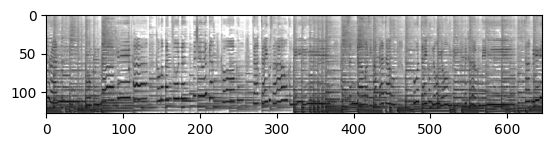

In [ ]:
def display_img(img, label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))


display_img(*train_dataset[0])

load the train and validation into batches.


In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_size = int(len(train_dataset) * PERCENT_VALIDATION)
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

# train_dl = DataLoader(train_data, BATCH, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, BATCH*2, num_workers = 4, pin_memory = True)

train_dl = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_data, batch_size=BATCH)
test_dl = DataLoader(test_dataset, batch_size=BATCH)

Length of Train Data : 2830
Length of Validation Data : 499


visualize a single batch of images


In [ ]:
from torchvision.utils import make_grid


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


# show_batch(train_dl)

Initialize model:


In [ ]:
# list all models
# dir(models)

initializing confusion matrix

In [ ]:
bcm = BinaryConfusionMatrix()

Function for training (one epoch)


In [ ]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    cum_loss = 0.0
    cum_correct = 0

    for x, y in tqdm(trainloader, total=len(trainloader), desc="Training"):
        (x, y) = (x.to(device), y.to(device))
        # print(y)
        # print(f'x device: {x.device}, y device: {y.device}')
        pred = model(x)
        # print(f'pred device a: {pred.device}')
        # pred = pred.to(device)
        # print(pred.shape)
        # print(f'pred device b: {pred.device}')
        # print(pred)
        # loss = nn.functional.binary_cross_entropy_with_logits(pred[:,1], y.float())
        loss = criterion(pred, y)
        # print(pred.dtype)
        # print(y.dtype)
        # loss = torchvision.ops.sigmoid_focal_loss(inputs=pred[:,1], targets=y.float(), alpha=ALPHA, gamma=GAMMA, reduction='mean')
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        cum_correct += (pred.argmax(1) == y).sum().item()

    # confusion_matrix = bcm(torch.tensor(y_pred), torch.tensor(y_target))
    epoch_acc = cum_correct / len(trainloader.dataset)
    epoch_loss = cum_loss / len(trainloader)
    return epoch_acc, epoch_loss

Function for testing (one epoch)


In [ ]:
def test(model, testloader, criterion):
    model.eval()
    cum_loss = 0.0
    cum_correct = 0

    with torch.no_grad():
        for x, y in tqdm(testloader, total=len(testloader), desc="Testing"):
            (x, y) = (x.to(device), y.to(device))
            pred = model(x).to(device)
            # loss = torchvision.ops.sigmoid_focal_loss(inputs=pred[:,1], targets=y.float(), alpha=ALPHA, gamma=GAMMA, reduction='mean')
            # loss = nn.functional.binary_cross_entropy_with_logits(pred[:,1], y.float())
            loss = criterion(pred,y)
            cum_loss += loss
            cum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_acc = cum_correct / len(testloader.dataset)
    epoch_loss = cum_loss / len(testloader)
    return epoch_acc, epoch_loss

Training and testing the model:


In [ ]:
# dictionary to keep track of losses and accuracies
H = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

# criterion = nn.functional.binary_cross_entropy_with_logits()

# train the model
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_acc, train_epoch_loss = train(model, train_dl, optimizer, criterion)
    test_epoch_acc, test_epoch_loss = test(model, test_dl, criterion)
    # print all the metrics
    print(f"Train loss: {train_epoch_loss:.4f} | Train acc: {train_epoch_acc:.4f}")
    print(f"Test loss: {test_epoch_loss:.4f} | Test acc: {test_epoch_acc:.4f}")
    H["train_loss"].append(train_epoch_loss)
    H["train_acc"].append(train_epoch_acc)
    H["test_loss"].append(test_epoch_loss)
    H["test_acc"].append(test_epoch_acc)

Epoch 1 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 5.7644 | Train acc: 0.1615
Test loss: 5.5768 | Test acc: 0.1246
Epoch 2 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 2.3168 | Train acc: 0.6046
Test loss: 1.1373 | Test acc: 0.5529
Epoch 3 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.8732 | Train acc: 0.6332
Test loss: 0.7798 | Test acc: 0.6075
Epoch 4 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.7216 | Train acc: 0.6276
Test loss: 0.7434 | Test acc: 0.5939
Epoch 5 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.6820 | Train acc: 0.6371
Test loss: 0.7278 | Test acc: 0.5956
Epoch 6 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.6606 | Train acc: 0.6452
Test loss: 0.7014 | Test acc: 0.6314
Epoch 7 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.6488 | Train acc: 0.6410
Test loss: 0.6942 | Test acc: 0.6263
Epoch 8 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.6399 | Train acc: 0.6456
Test loss: 0.6900 | Test acc: 0.6297
Epoch 9 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.6316 | Train acc: 0.6562
Test loss: 0.6828 | Test acc: 0.6348
Epoch 10 of 10


Training:   0%|          | 0/89 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Train loss: 0.6215 | Train acc: 0.6558
Test loss: 0.6873 | Test acc: 0.6280


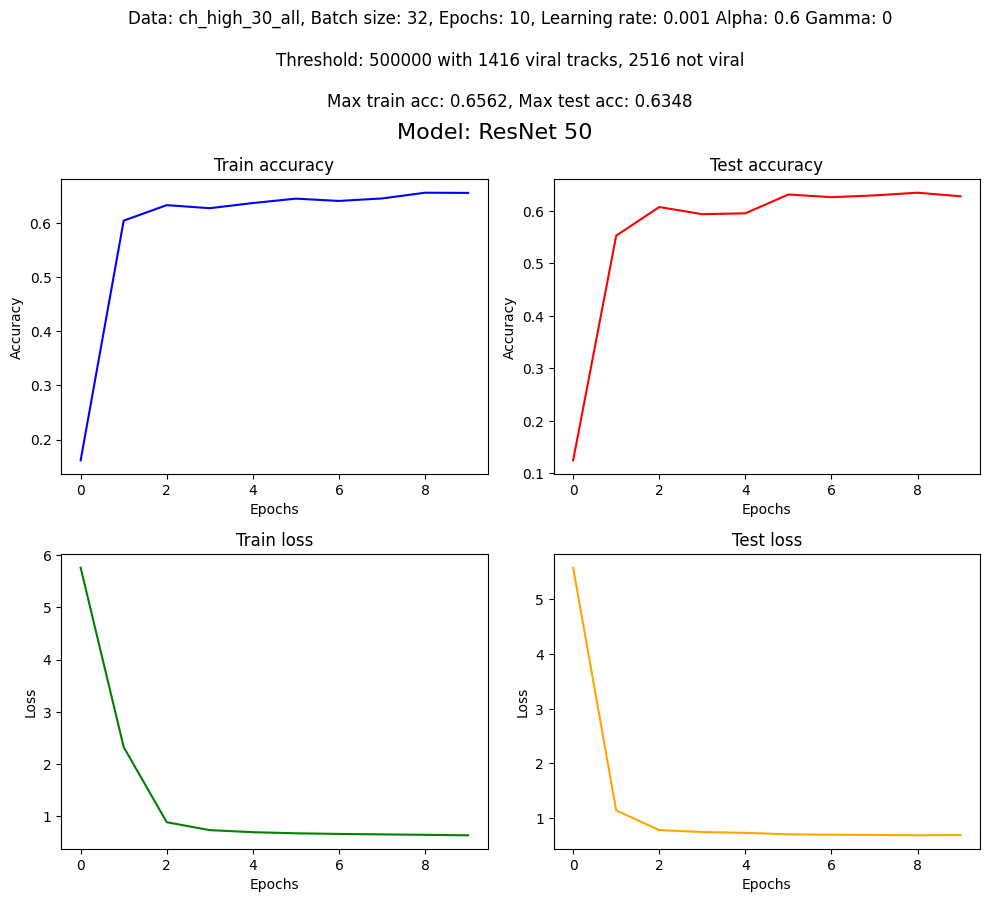

In [ ]:
max_train_acc = max(H["train_acc"])
max_test_acc = max(H["test_acc"])

fig = plt.figure(figsize=(10, 8))
# supertitle
fig.suptitle(f'Model: {model_name}', fontsize=16)
info = f"""Data: {dir_name}, Batch size: {BATCH}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE} Alpha: {ALPHA} Gamma: {GAMMA}\n
Threshold: {HIGH_THRESHOLD} with {num_viral} viral tracks, {num_not_viral} not viral\n
Max train acc: {max_train_acc:.4f}, Max test acc: {max_test_acc:.4f}"""
fig.text(0.515, 1, info, ha="center", fontsize=12)


sub1 = fig.add_subplot(221)
sub1.set_title("Train accuracy")
sub1.plot(H["train_acc"], color="blue", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub2 = fig.add_subplot(222)
sub2.set_title("Test accuracy")
sub2.plot(H["test_acc"], color="red", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub3 = fig.add_subplot(223)
sub3.set_title("Train loss")
sub3.plot(H["train_loss"], color="green", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")


sub4 = fig.add_subplot(224)
sub4.set_title("Test loss")
sub4.plot([l.item() for l in H["test_loss"]], color="orange", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

In [ ]:
metric = BinaryConfusionMatrix().to(device)
model.eval()

with torch.no_grad():
  for i, (x, y) in enumerate(train_dl):
    # if i==2:
      # break
    (x, y) = (x.to(device), y.to(device))
    pred = model(x).to(device)
    metric.update(pred[:,1], y)

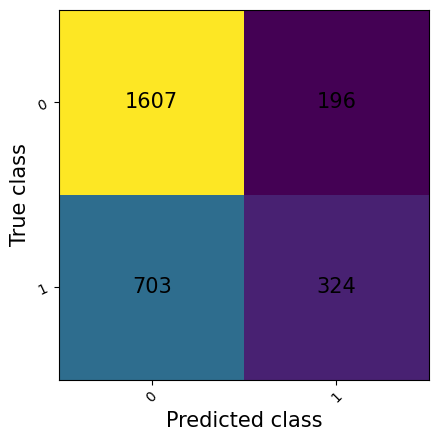

In [ ]:
fig, ax = metric.plot()